<a href="https://colab.research.google.com/github/Ithomas13/Isaiah-Thomas-Projects/blob/main/Diabetes_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
44# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Function to collect daily data from the user (Manual Entry)
def collect_daily_data():
    print("\nPlease input your daily health data:")
    try:
        morning_blood_sugar = float(input("Morning (fasting) blood sugar (mg/dL): "))
        post_breakfast_blood_sugar = float(input("Blood sugar 1 hour after breakfast (mg/dL): "))
        post_lunch_blood_sugar = float(input("Blood sugar 1 hour after lunch (mg/dL): "))
        post_dinner_blood_sugar = float(input("Blood sugar 1 hour after dinner (mg/dL): "))
        before_bed_blood_sugar = float(input("Before bed blood sugar (mg/dL): "))
        sleep_hours = float(input("Hours of sleep: "))
        stress_level = int(input("Perceived stress level (1-10): "))
        exercise_minutes = int(input("Exercise minutes: "))
        irregular_diet_input = input("Did you have an irregular diet today? (yes/no): ").strip().lower()
        if irregular_diet_input not in ['yes', 'no']:
            raise ValueError("Invalid input for irregular diet. Please enter 'yes' or 'no'.")
        irregular_diet = irregular_diet_input == "yes"

        data = {
            "day": None,  # To be filled later if manual
            "morning_blood_sugar": morning_blood_sugar,
            "post_breakfast_blood_sugar": post_breakfast_blood_sugar,
            "post_lunch_blood_sugar": post_lunch_blood_sugar,
            "post_dinner_blood_sugar": post_dinner_blood_sugar,
            "before_bed_blood_sugar": before_bed_blood_sugar,
            "sleep_hours": sleep_hours,
            "stress_level": stress_level,
            "exercise_minutes": exercise_minutes,
            "irregular_diet": irregular_diet
        }

        return data

    except ValueError as ve:
        print(f"Input Error: {ve}")
        print("Please re-enter the data for this day.\n")
        return collect_daily_data()

# Blood sugar rating calculation with the finalized weighting
def calculate_blood_sugar_rating(data):
    morning_weight = 0.40
    post_meal_weight = 0.30
    before_bed_weight = 0.30

    post_meal_avg = (data["post_breakfast_blood_sugar"] + data["post_lunch_blood_sugar"] + data["post_dinner_blood_sugar"]) / 3
    weighted_rating = (data["morning_blood_sugar"] * morning_weight) + (post_meal_avg * post_meal_weight) + (data["before_bed_blood_sugar"] * before_bed_weight)

    return weighted_rating

# Step 2A: Function to collect data for multiple days (Manual Entry)
def collect_weekly_data_manual():
    while True:
        try:
            days = int(input("\nHow many days of data do you want to input? "))
            if days < 1:
                raise ValueError("Number of days must be at least 1.")
            break
        except ValueError as ve:
            print(f"Input Error: {ve}")
            print("Please enter a valid number of days.\n")

    weekly_data = []
    for _ in range(days):
        daily_data = collect_daily_data()
        daily_data["blood_sugar_rating"] = calculate_blood_sugar_rating(daily_data)
        weekly_data.append(daily_data)
        print(f"Blood Sugar Rating for the day: {daily_data['blood_sugar_rating']:.2f}\n")
    df = pd.DataFrame(weekly_data)
    return df

# Step 2B: Function to collect data from a two-week data set (Single-Line Input)
def collect_weekly_data_dataset():
    print("\nPlease paste your two-week data set below in the specified format.")
    print("Each day's data should be separated by a pipe '|' symbol.")
    print("Within each day, fields should be separated by double hyphens '--'.")
    print("\nExample:")
    print("1--125--17--155--160--140--8.5--3--45--No|2--110--160--145--150--135--7.5--4--35--No|...")
    print("\nPlease paste all 14 days of data in a single line and press Enter.\n")

    # Prompt user to paste all data at once
    data_text = input("Paste your two-week data set here:\n")

    # Split the input into days using '|'
    data_days = data_text.strip().split('|')

    if len(data_days) != 14:
        print(f"\nError: Expected 14 days of data separated by '|', but received {len(data_days)} days.")
        print("Please ensure you have exactly 14 days of data separated by '|'.\n")
        return collect_weekly_data_dataset()

    weekly_data = []
    for line in data_days:
        parts = line.strip().split("--")
        if len(parts) != 10:
            print(f"Incorrect format in line: {line}")
            continue  # Skip this line

        try:
            day = int(parts[0])
            morning_blood_sugar = float(parts[1])
            post_breakfast_blood_sugar = float(parts[2])
            post_lunch_blood_sugar = float(parts[3])
            post_dinner_blood_sugar = float(parts[4])
            before_bed_blood_sugar = float(parts[5])
            sleep_hours = float(parts[6])
            stress_level = int(parts[7])
            exercise_minutes = int(parts[8])
            irregular_diet_input = parts[9].strip().lower()
            if irregular_diet_input not in ['yes', 'no']:
                raise ValueError("Irregular diet must be 'Yes' or 'No'.")
            irregular_diet = irregular_diet_input == "yes"

            data = {
                "day": day,
                "morning_blood_sugar": morning_blood_sugar,
                "post_breakfast_blood_sugar": post_breakfast_blood_sugar,
                "post_lunch_blood_sugar": post_lunch_blood_sugar,
                "post_dinner_blood_sugar": post_dinner_blood_sugar,
                "before_bed_blood_sugar": before_bed_blood_sugar,
                "sleep_hours": sleep_hours,
                "stress_level": stress_level,
                "exercise_minutes": exercise_minutes,
                "irregular_diet": irregular_diet
            }

            data["blood_sugar_rating"] = calculate_blood_sugar_rating(data)
            weekly_data.append(data)

        except ValueError as ve:
            print(f"Data Parsing Error in line: {line} --> {ve}")
            continue  # Skip this line

    if not weekly_data:
        print("No valid data was entered. Switching to manual data entry.\n")
        return collect_weekly_data_manual()

    if len(weekly_data) < 14:
        print(f"Warning: Only {len(weekly_data)} out of 14 days were successfully parsed and included.\n")

    df = pd.DataFrame(weekly_data)
    print("\nData imported successfully!\n")
    return df

# Step 3: Machine learning - Correlation analysis using Linear Regression
def run_machine_learning_analysis(data):
    # Filter out days with irregular diets
    clean_data = data[data["irregular_diet"] == False]

    if len(clean_data) > 1:  # Only run if we have enough data
        X = clean_data[["sleep_hours", "stress_level", "exercise_minutes"]]
        y = clean_data["blood_sugar_rating"]

        # Train a linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Predict on the same data
        y_pred = model.predict(X)

        # Evaluate the model
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        correlation_results = dict(zip(X.columns, model.coef_))

        # Display results
        print("\n--- Machine Learning Analysis Results ---")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"R-squared (Model Accuracy): {r2 * 100:.2f}%")
        print("Correlations (for Sleep, Stress, Exercise):")
        for feature, coef in correlation_results.items():
            print(f"{feature.replace('_', ' ').title()}: {coef:.4f}")

        # Summary of Factor Influences
        print("\n--- Factor Influence Summary ---")
        # Sort factors by absolute value of coefficients in descending order
        sorted_factors = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)
        for idx, (feature, coef) in enumerate(sorted_factors, 1):
            direction = "negatively" if coef < 0 else "positively"
            print(f"{idx}. **{feature.replace('_', ' ').title()}**")
            print(f"   - **Impact:** {feature.replace('_', ' ').title()} {'has the most significant impact' if idx == 1 else 'is the next most influential factor'} on your blood sugar levels.")
            # Explanation based on coefficient
            if feature == "sleep_hours":
                if coef < 0:
                    print(f"   - **Explanation:** On days when you slept less, your blood sugar levels tended to be higher. Adequate sleep helps regulate hormones that control blood sugar.")
                else:
                    print(f"   - **Explanation:** On days when you slept more, your blood sugar levels tended to be higher. (This is unlikely but included for completeness.)")
            elif feature == "stress_level":
                if coef < 0:
                    print(f"   - **Explanation:** On days with lower stress, your blood sugar levels tended to be higher. (This is unlikely but included for completeness.)")
                else:
                    print(f"   - **Explanation:** On days with higher stress, your blood sugar levels tended to be higher. High stress triggers hormones like cortisol, which can raise blood sugar levels.")
            elif feature == "exercise_minutes":
                if coef < 0:
                    print(f"   - **Explanation:** On days when you exercised more, your blood sugar levels tended to be higher. (This is unlikely but included for completeness.)")
                else:
                    print(f"   - **Explanation:** On days when you exercised more, your blood sugar levels tended to be higher. (This is unlikely but included for completeness.)")

            # Recommendation based on the factor
            if feature == "sleep_hours":
                print(f"   - **Recommendation:** Aim for **7-8 hours of quality sleep** each night. Establish a consistent sleep schedule and create a restful environment.")
            elif feature == "stress_level":
                print(f"   - **Recommendation:** Incorporate **stress-reducing activities** into your daily routine, such as meditation, deep breathing exercises, or yoga.")
            elif feature == "exercise_minutes":
                print(f"   - **Recommendation:** Strive for at least **150 minutes of moderate-intensity exercise** each week, including activities like brisk walking, cycling, or swimming.")
            print()  # Add an empty line for readability

        # Provide actionable recommendations
        print("--- Actionable Recommendations ---")
        for feature, coef in sorted_factors:
            if feature == "sleep_hours":
                print("- **Sleep Hours:** Ensure you maintain consistent sleep patterns. Aim for 7-8 hours of sleep to help manage blood sugar levels.")
            elif feature == "stress_level":
                print("- **Stress Level:** Practice stress management techniques such as mindfulness, exercise, or hobbies you enjoy.")
            elif feature == "exercise_minutes":
                print("- **Exercise Minutes:** Incorporate regular physical activity into your daily schedule. Even short bouts of exercise can make a difference.")
        print()

        # Predictions vs Actual Values
        print("--- Predictions vs Actual Values ---")
        for pred, actual in zip(y_pred, y):
            print(f"Predicted: {pred:.2f}, Actual: {actual:.2f}")

    else:
        print("\nNot enough valid data (without irregular diet days) to run machine learning analysis.")

# Step 4: Run the full program
def main():
    print("Welcome to the Diabetes Monitoring Program")
    print("Please choose your data input method:")
    print("1. Manual Data Entry")
    print("2. Upload Two-Week Data Set")

    while True:
        choice = input("\nEnter 1 for Manual or 2 for Data Set: ").strip()
        if choice == '1':
            weekly_data = collect_weekly_data_manual()
            break
        elif choice == '2':
            weekly_data = collect_weekly_data_dataset()
            break
        else:
            print("Invalid choice. Please enter 1 or 2.\n")

    print("\nCollected Data:")
    print(weekly_data)

    run_machine_learning_analysis(weekly_data)
    print("\n--- End of Program ---")

# Run the main function
if __name__ == "__main__":
    main()


Welcome to the Diabetes Monitoring Program
Please choose your data input method:
1. Manual Data Entry
2. Upload Two-Week Data Set

Enter 1 for Manual or 2 for Data Set: 2

Please paste your two-week data set below in the specified format.
Each day's data should be separated by a pipe '|' symbol.
Within each day, fields should be separated by double hyphens '--'.

Example:
1--125--17--155--160--140--8.5--3--45--No|2--110--160--145--150--135--7.5--4--35--No|...

Please paste all 14 days of data in a single line and press Enter.

Paste your two-week data set here:
1--120--150--140--160--130--7.0--5--30--No|2--110--145--135--150--125--8.0--3--45--No|3--130--160--150--170--140--6.5--7--20--Yes|4--115--140--130--155--120--7.5--4--40--No|5--125--155--145--165--135--6.0--8--15--Yes|6--105--130--120--140--110--7.8--6--25--No|7--118--145--135--150--125--6.2--7--10--No|8--112--138--128--142--115--8.5--3--50--No|9--132--158--148--168--138--5.8--9--0--Yes|10--107--130--120--140--115--7.0--4--35--No

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Welcome to the Diabetes Monitoring Program
Please choose your data input method:
1. Manual Data Entry
2. Upload Two-Week Data Set

Enter 1 for Manual or 2 for Data Set: 2

Please paste your two-week data set below in the specified format.
Each day's data should be separated by a pipe '|' symbol.
Within each day, fields should be separated by double hyphens '--'.

Example:
1--125--17--155--160--140--8.5--3--45--No|2--110--160--145--150--135--7.5--4--35--No|...

Please paste all 14 days of data in a single line and press Enter.

Paste your two-week data set here:
1--120--150--140--160--130--7.0--5--30--No|2--110--145--135--150--125--8.0--3--45--No|3--130--160--150--170--140--6.5--7--20--Yes|4--115--140--130--155--120--7.5--4--40--No|5--125--155--145--165--135--6.0--8--15--Yes|6--105--130--120--140--110--7.8--6--25--No|7--118--145--135--150--125--6.2--7--10--No|8--112--138--128--142--115--8.5--3--50--No|9--132--158--148--168--138--5.8--9--0--Yes|10--107--130--120--140--115--7.0--4--35--No

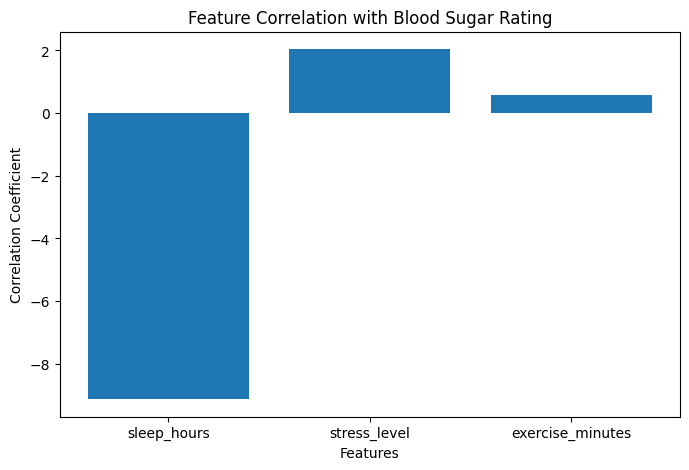

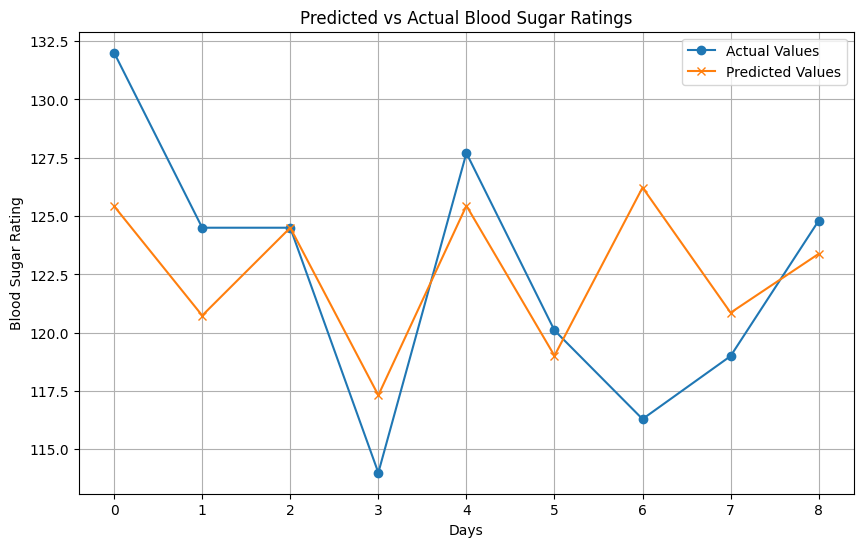


--- End of Program ---


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Function to collect daily data from the user (Manual Entry)
def collect_daily_data():
    print("\nPlease input your daily health data:")
    try:
        morning_blood_sugar = float(input("Morning (fasting) blood sugar (mg/dL): "))
        post_breakfast_blood_sugar = float(input("Blood sugar 1 hour after breakfast (mg/dL): "))
        post_lunch_blood_sugar = float(input("Blood sugar 1 hour after lunch (mg/dL): "))
        post_dinner_blood_sugar = float(input("Blood sugar 1 hour after dinner (mg/dL): "))
        before_bed_blood_sugar = float(input("Before bed blood sugar (mg/dL): "))
        sleep_hours = float(input("Hours of sleep: "))
        stress_level = int(input("Perceived stress level (1-10): "))
        exercise_minutes = int(input("Exercise minutes: "))
        irregular_diet_input = input("Did you have an irregular diet today? (yes/no): ").strip().lower()
        if irregular_diet_input not in ['yes', 'no']:
            raise ValueError("Invalid input for irregular diet. Please enter 'yes' or 'no'.")
        irregular_diet = irregular_diet_input == "yes"

        data = {
            "day": None,  # To be filled later if manual
            "morning_blood_sugar": morning_blood_sugar,
            "post_breakfast_blood_sugar": post_breakfast_blood_sugar,
            "post_lunch_blood_sugar": post_lunch_blood_sugar,
            "post_dinner_blood_sugar": post_dinner_blood_sugar,
            "before_bed_blood_sugar": before_bed_blood_sugar,
            "sleep_hours": sleep_hours,
            "stress_level": stress_level,
            "exercise_minutes": exercise_minutes,
            "irregular_diet": irregular_diet
        }

        return data

    except ValueError as ve:
        print(f"Input Error: {ve}")
        print("Please re-enter the data for this day.\n")
        return collect_daily_data()

# Blood sugar rating calculation with the finalized weighting
def calculate_blood_sugar_rating(data):
    morning_weight = 0.40
    post_meal_weight = 0.30
    before_bed_weight = 0.30

    post_meal_avg = (data["post_breakfast_blood_sugar"] + data["post_lunch_blood_sugar"] + data["post_dinner_blood_sugar"]) / 3
    weighted_rating = (data["morning_blood_sugar"] * morning_weight) + (post_meal_avg * post_meal_weight) + (data["before_bed_blood_sugar"] * before_bed_weight)

    return weighted_rating

# Step 2A: Function to collect data for multiple days (Manual Entry)
def collect_weekly_data_manual():
    while True:
        try:
            days = int(input("\nHow many days of data do you want to input? "))
            if days < 1:
                raise ValueError("Number of days must be at least 1.")
            break
        except ValueError as ve:
            print(f"Input Error: {ve}")
            print("Please enter a valid number of days.\n")

    weekly_data = []
    for _ in range(days):
        daily_data = collect_daily_data()
        daily_data["blood_sugar_rating"] = calculate_blood_sugar_rating(daily_data)
        weekly_data.append(daily_data)
        print(f"Blood Sugar Rating for the day: {daily_data['blood_sugar_rating']:.2f}\n")
    df = pd.DataFrame(weekly_data)
    return df

# Step 2B: Function to collect data from a two-week data set (Single-Line Input)
def collect_weekly_data_dataset():
    print("\nPlease paste your two-week data set below in the specified format.")
    print("Each day's data should be separated by a pipe '|' symbol.")
    print("Within each day, fields should be separated by double hyphens '--'.")
    print("\nExample:")
    print("1--125--17--155--160--140--8.5--3--45--No|2--110--160--145--150--135--7.5--4--35--No|...")
    print("\nPlease paste all 14 days of data in a single line and press Enter.\n")

    # Prompt user to paste all data at once
    data_text = input("Paste your two-week data set here:\n")

    # Split the input into days using '|'
    data_days = data_text.strip().split('|')

    if len(data_days) != 14:
        print(f"\nError: Expected 14 days of data separated by '|', but received {len(data_days)} days.")
        print("Please ensure you have exactly 14 days of data separated by '|'.\n")
        return collect_weekly_data_dataset()

    weekly_data = []
    for line in data_days:
        parts = line.strip().split("--")
        if len(parts) != 10:
            print(f"Incorrect format in line: {line}")
            continue  # Skip this line

        try:
            day = int(parts[0])
            morning_blood_sugar = float(parts[1])
            post_breakfast_blood_sugar = float(parts[2])
            post_lunch_blood_sugar = float(parts[3])
            post_dinner_blood_sugar = float(parts[4])
            before_bed_blood_sugar = float(parts[5])
            sleep_hours = float(parts[6])
            stress_level = int(parts[7])
            exercise_minutes = int(parts[8])
            irregular_diet_input = parts[9].strip().lower()
            if irregular_diet_input not in ['yes', 'no']:
                raise ValueError("Irregular diet must be 'Yes' or 'No'.")
            irregular_diet = irregular_diet_input == "yes"

            data = {
                "day": day,
                "morning_blood_sugar": morning_blood_sugar,
                "post_breakfast_blood_sugar": post_breakfast_blood_sugar,
                "post_lunch_blood_sugar": post_lunch_blood_sugar,
                "post_dinner_blood_sugar": post_dinner_blood_sugar,
                "before_bed_blood_sugar": before_bed_blood_sugar,
                "sleep_hours": sleep_hours,
                "stress_level": stress_level,
                "exercise_minutes": exercise_minutes,
                "irregular_diet": irregular_diet
            }

            data["blood_sugar_rating"] = calculate_blood_sugar_rating(data)
            weekly_data.append(data)

        except ValueError as ve:
            print(f"Data Parsing Error in line: {line} --> {ve}")
            continue  # Skip this line

    if not weekly_data:
        print("No valid data was entered. Switching to manual data entry.\n")
        return collect_weekly_data_manual()

    if len(weekly_data) < 14:
        print(f"Warning: Only {len(weekly_data)} out of 14 days were successfully parsed and included.\n")

    df = pd.DataFrame(weekly_data)
    print("\nData imported successfully!\n")
    return df

# Step 3: Machine learning - Correlation analysis using Linear Regression
def run_machine_learning_analysis(data):
    # Filter out days with irregular diets
    clean_data = data[data["irregular_diet"] == False]

    if len(clean_data) > 1:  # Only run if we have enough data
        X = clean_data[["sleep_hours", "stress_level", "exercise_minutes"]]
        y = clean_data["blood_sugar_rating"]

        # Train a linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Predict on the same data
        y_pred = model.predict(X)

        # Evaluate the model
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        correlation_results = dict(zip(X.columns, model.coef_))

        # Display results
        print("\n--- Machine Learning Analysis Results ---")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"R-squared (Model Accuracy): {r2 * 100:.2f}%")
        print("Correlations (for Sleep, Stress, Exercise):")
        for feature, coef in correlation_results.items():
            print(f"{feature.replace('_', ' ').title()}: {coef:.4f}")

        # Graphing correlation results
        plt.figure(figsize=(8, 5))
        plt.bar(correlation_results.keys(), correlation_results.values())
        plt.title('Feature Correlation with Blood Sugar Rating')
        plt.ylabel('Correlation Coefficient')
        plt.xlabel('Features')
        plt.show()

        # Predictions vs Actual Values
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y)), y, label="Actual Values", marker='o')
        plt.plot(range(len(y_pred)), y_pred, label="Predicted Values", marker='x')
        plt.title('Predicted vs Actual Blood Sugar Ratings')
        plt.ylabel('Blood Sugar Rating')
        plt.xlabel('Days')
        plt.legend()
        plt.grid()
        plt.show()

    else:
        print("\nNot enough valid data (without irregular diet days) to run machine learning analysis.")

# Step 4: Run the full program
def main():
    print("Welcome to the Diabetes Monitoring Program")
    print("Please choose your data input method:")
    print("1. Manual Data Entry")
    print("2. Upload Two-Week Data Set")

    while True:
        choice = input("\nEnter 1 for Manual or 2 for Data Set: ").strip()
        if choice == '1':
            weekly_data = collect_weekly_data_manual()
            break
        elif choice == '2':
            weekly_data = collect_weekly_data_dataset()
            break
        else:
            print("Invalid choice. Please enter 1 or 2.\n")

    print("\nCollected Data:")
    print(weekly_data)

    run_machine_learning_analysis(weekly_data)
    print("\n--- End of Program ---")

# Run the main function
if __name__ == "__main__":
    main()
